# Hitting Time Stats (Minute)

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
close_data = pd.read_csv("SPY_underlying_price_min.csv") [['time', 'close']]
close_data["time"] = pd.to_datetime(close_data["time"])
close_data.dropna(inplace=True)
close_data.set_index("time", inplace=True)

# Set the name of the column to SPY
close_data.columns = ["SPY"]

In [3]:
# Define 1% as alpha
alpha = (close_data.iloc[0] * 0.005)[0]
alphas = pd.DataFrame({"SPY": alpha}, index=[0])
alphas

,SPY
0,1.02025


In [4]:
def hitting_time_record_adaptive_alpha(time_indices, values, alpha_pct):
    last_hit_value = values[0]
    hit_times = [time_indices[0]]
    hitted_values = [values[0]]
    alpha = values[0] * alpha_pct
    alphas = [alpha]
    for i in range(1, len(values)):
        if abs(last_hit_value - values[i]) >= alpha:
            alpha = values[i] * alpha_pct
            alphas.append(alpha)
            hit_times.append(time_indices[i])
            last_hit_value = values[i]
            hitted_values.append(values[i])
    return hit_times, hitted_values, alphas

def hitting_time_record_fixed_alpha(time_indices, values, alpha):
    last_hit_value = values[0]
    hit_times = [time_indices[0]]
    hitted_values = [values[0]]
    for i in range(1, len(values)):
        if abs(last_hit_value - values[i]) >= alpha:
            
            hit_times.append(time_indices[i])
            last_hit_value = values[i]
            hitted_values.append(values[i])
    return hit_times, hitted_values

In [5]:
hit_times, hit_values = hitting_time_record_fixed_alpha(close_data.index.tolist(), close_data["SPY"].tolist(), alpha)

hit_times_adaptive, hit_values_adaptive, alpha_dynamics = hitting_time_record_adaptive_alpha(close_data.index.tolist(), close_data["SPY"].tolist(), 0.005)

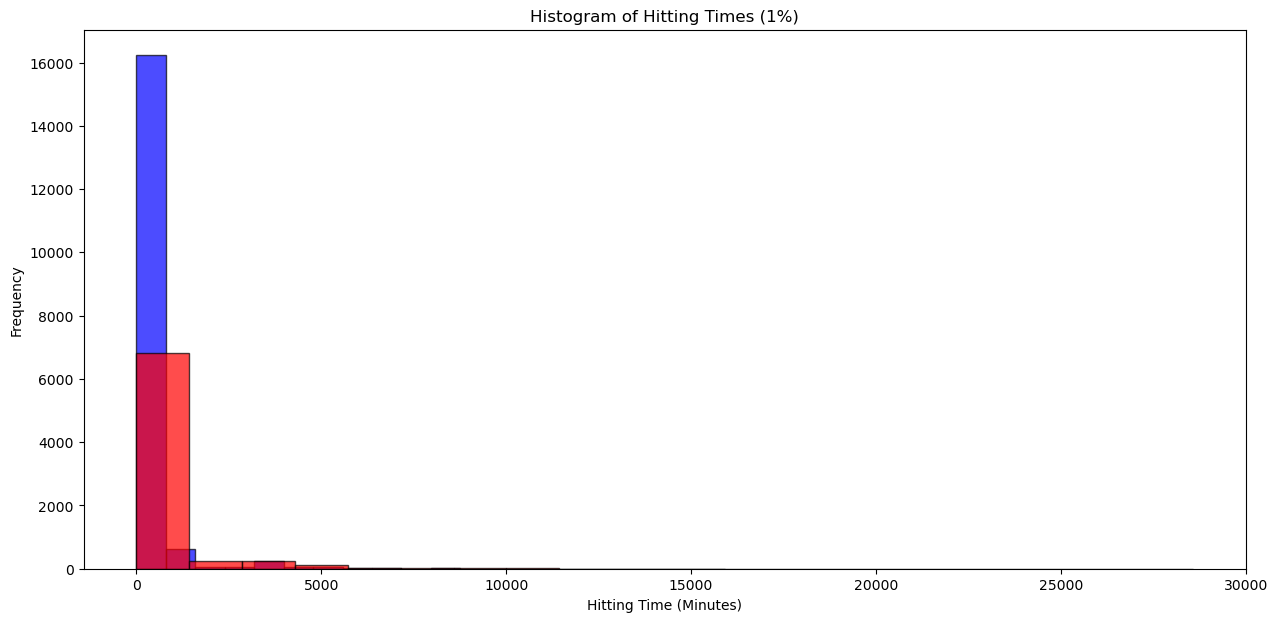

In [6]:
# Get difference between hitting times in days
hit_times_diff = np.diff(hit_times)
hit_time_diff_adaptive = np.diff(hit_times_adaptive)

# Convert Timedelta to days
hit_times_diff = [time.total_seconds()/60 for time in hit_times_diff]
hit_time_diff_adaptive = [time.total_seconds()/60 for time in hit_time_diff_adaptive]

# Plot histogram of hitting times
plt.figure(figsize=(15, 7))
plt.hist(hit_times_diff, bins=20, edgecolor="black", color="blue", alpha=0.7, label="Fixed Alpha")
plt.hist(hit_time_diff_adaptive, bins=20, edgecolor="black", color="red", alpha=0.7, label="Adaptive Alpha")
plt.title("Histogram of Hitting Times (1%)")
plt.xlabel("Hitting Time (Minutes)")
plt.ylabel("Frequency")
plt.show()


# Expected Length (Theoretical)

$$\mathbb{E}[L(\alpha, T)] \approx \frac{\mathbb{E}[X^2_T]}{\alpha^2}$$

Under the assumptions from previous formula of Bachelier Dynamic, $$dX_t =  \mu dt + \sigma dW_t,$$

we have 

$$\delta X_t = \mu \delta t + \sigma \sqrt{\delta_t} \phi_t,$$

where $\phi_t \sim \mathcal{N}(0, 1)$.

By turning into a regression problem to estimate the parameters $\mu$ and $\sigma$, we have

$$\delta x_t = \mu t + \epsilon_t$$

where $\epsilon_t ~ \mathcal{N}(0, \sigma^2 t)$. 


Therefore, 

$$var(\epsilon | X) = \sigma^2 V(X)$$

and 
$$V(X) = diag(X)$$


Option reserach direction: Find a better daily volatility correlation to remodel.

In [7]:
realized_expected_length = (len(hit_times)*alphas["SPY"]**2)[0]

# Estimate the $\mu$ and $\sigma$ by Generalized Least Squares (WLS)

I know this could be very wrong. But I want to see how it goes.

In [8]:
delta_ts = [x.total_seconds()/60 for x in close_data["SPY"].index.to_series().diff()][1:]
delta_s = close_data["SPY"].diff().values[1:]

delta_s = delta_s / np.sqrt(delta_ts)
delta_ts = np.sqrt(delta_ts)

In [9]:
# Linear Regression
X = np.array(delta_ts).reshape(-1, 1)
Y = np.array(delta_s).reshape(-1, 1)

beta = np.linalg.inv(X.T @ X) @ X.T @ Y
sigma = np.sqrt(np.var(Y, ddof=1))

print(f"Estimated beta: {beta}")
print(f"Estimated sigma: {sigma}")

Estimated beta: [[6.96062484e-05]]
Estimated sigma: 0.1329283177212107


In [10]:
# Insanity Check

vol = sigma * np.sqrt(365*24*60) / close_data["SPY"].mean()

print(f"Estimated Volatility: {vol}")

Estimated Volatility: 0.2916680060829854


In [11]:
SPY_alpha = alphas["SPY"][0]

In [12]:
# Based on estimated beta and sigma
T = (close_data["SPY"].index[-1] - close_data["SPY"].index[0]).total_seconds() / 60
expected_XT = (close_data["SPY"].values[0] + beta[0] * T)[0] - close_data["SPY"].values[0]
print(f"Expected X_T: {expected_XT}")
print(f"Expected X_T^2: {expected_XT**2}")

expected_length_data = expected_XT**2 / SPY_alpha**2
print(f"Expected Length Based on Data: {expected_length_data}")
print(f"Realized Length: {realized_expected_length}")
print(f"Maximal Length: {len(close_data.index) * SPY_alpha**2}")

Expected X_T: 296.889999999996
Expected X_T^2: 88143.67209999762
Expected Length Based on Data: 84679.43127410933
Realized Length: 18129.530558562506
Maximal Length: 1665259.367998188


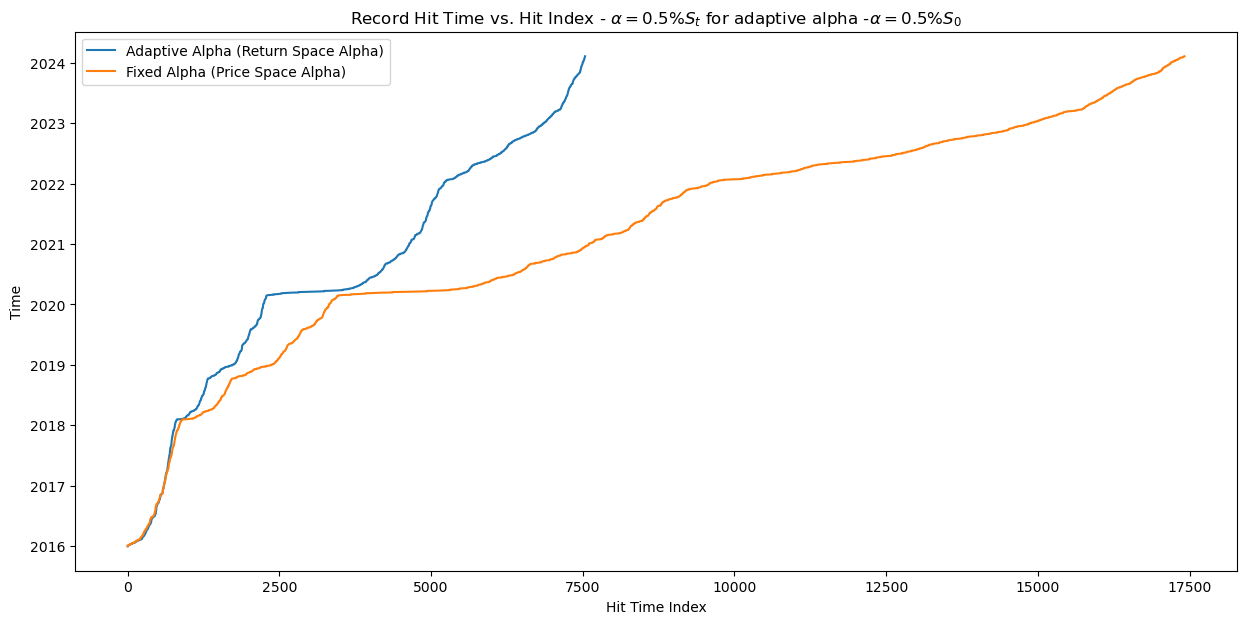

In [13]:
# Plot alpha dynamics
plt.figure(figsize=(15, 7))
plt.plot(hit_times_adaptive, label="Adaptive Alpha (Return Space Alpha)")
plt.plot(hit_times, label="Fixed Alpha (Price Space Alpha)")
plt.title(f"Record Hit Time vs. Hit Index - $\\alpha = 0.5\% S_t$ for adaptive alpha -$\\alpha = 0.5\% S_0$")
plt.xlabel("Hit Time Index")
plt.ylabel("Time")
plt.legend()
plt.show()

# Skorokhod's Second Embedding Theorem

Let $X_t$ be a sequence of iid random variables with mean 0 and finite variance, and let $S_n = X_1 + X_2 + \cdots + X_n$.

Then there is a sequence of stopping time $\tau_n$ such that the $W_{\tau_n}$ have the same joint distribution s as the partial sum $S_n$ and $\tau_1$, $\tau_2-\tau_1$, $\tau_3-\tau_2$, ... are iid random variables satisfying $\mathbb{E}[\tau_n - \tau_{n-1}] = \mathbb{E}[X_1^2]$ and $\mathbb{E}[ (\tau_n - \tau_{n-1})^2 ] = 4\mathbb{E}[X_1^4]$

# Problem 1

Find best $\{ (T_i, T_{i+1}) \}$ s.t. $ | \mathbb{E}[X_i^2] - \mathbb{E}[X_j^2] | \leq \alpha_\sigma $ where $i \in [T_i, T_{i+1}]$ and $j \in [T_j, T_{j+1}]$.


# Problem 2

Find best $\{(T_i, T_{i+1})\}$ s.t. $ | \mathbb{E}[X_i^4] - \mathbb{E}[X_j^4] | \leq \kappa_\sigma $ where $i \in [T_i, T_{i+1}]$ and $j \in [T_j, T_{j+1}]$.

Exploring the data a bit more: 

# Volatility Estimation

We have 
$$\sigma^2 = \frac{\alpha^2}{\mathbf{E}[\tau]}$$

Or $$\mathbf{E}[\tau] = \frac{\alpha^2}{\sigma^2}$$

Moreover, we have 
$$Var[\tau] = \frac{2}{3} \frac{\alpha^4}{\sigma^4}$$

In [14]:
diff_tau_df = pd.DataFrame({'hit_times': hit_times}, index=hit_times).diff().dropna()
diff_tau_df.head()

diff_tau_df_log = pd.DataFrame({'hit_times': hit_times_adaptive}, index=hit_times_adaptive).diff().dropna()
diff_tau_df_log.head()

,hit_times
2016-01-04 04:00:00-05:00,3 days 08:59:00
2016-01-04 07:16:00-05:00,0 days 03:16:00
2016-01-04 11:01:00-05:00,0 days 03:45:00
2016-01-04 12:54:00-05:00,0 days 01:53:00
2016-01-04 15:59:00-05:00,0 days 03:05:00


In [38]:
rolling_var_moved_base = alpha ** 2 / diff_tau_df.apply(lambda x: x[0].total_seconds() / 60, axis = 1).rolling(window=30).mean()
rolling_var_moved_base_log = alpha ** 2 / diff_tau_df_log.apply(lambda x: x[0].total_seconds() / 60, axis = 1).rolling(window=30).mean()


Comparing to VIX


In [39]:
vix_data = pd.read_csv("VIX9D_History.csv", parse_dates=["DATE"], index_col=0)
vix_data.head()

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2011-01-04,16.06,16.06,16.06,16.06
2011-01-05,15.57,15.57,15.57,15.57
2011-01-06,15.71,15.71,15.71,15.71
2011-01-07,15.01,15.01,15.01,15.01
2011-01-10,15.81,15.81,15.81,15.81


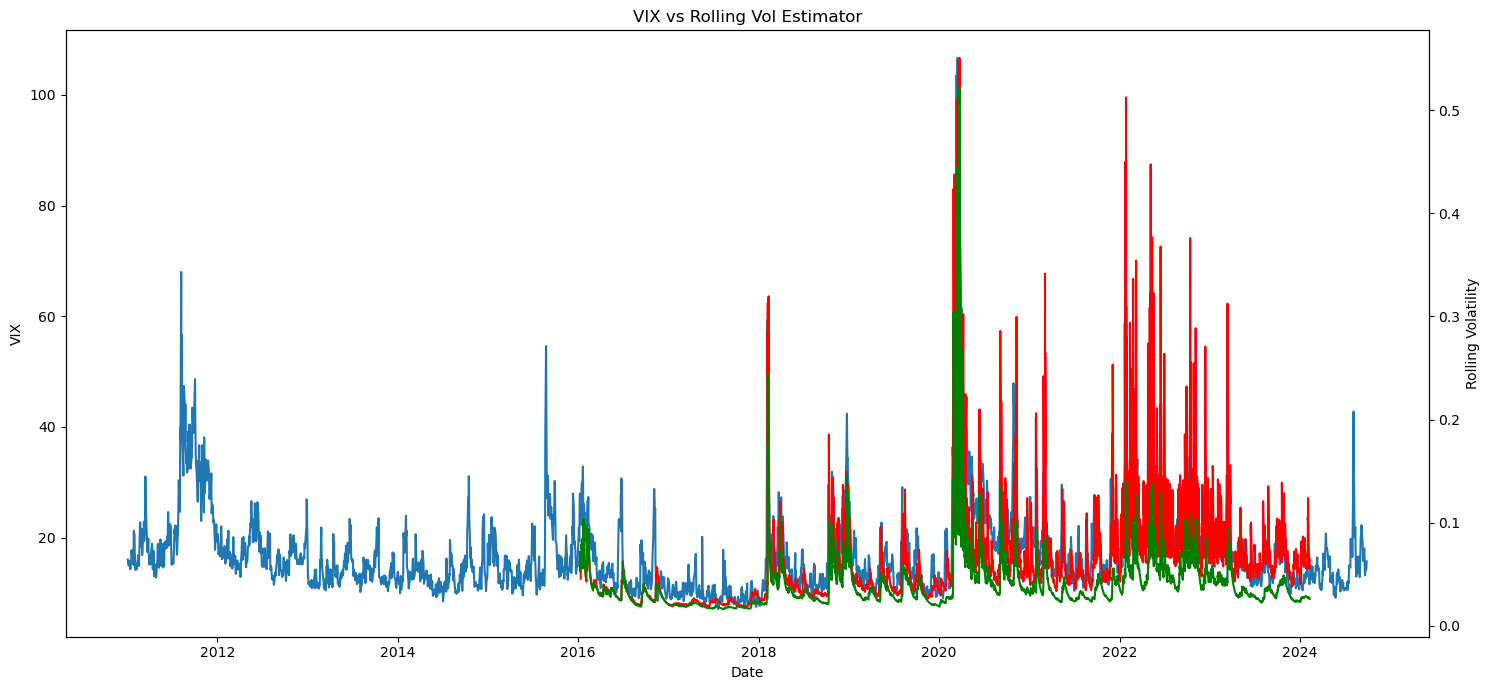

In [40]:
# Plot VIX and rolling_vol_moved_base with two y-axes

fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot VIX on the left y-axis (primary y-axis)
ax1.plot(vix_data["CLOSE"], label='VIX')
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot rolling_vol_moved_base on the right y-axis (secondary y-axis)
ax2.plot(np.sqrt(rolling_var_moved_base), label='Rolling Vol Estimator', color='red')
ax2.plot(np.sqrt(rolling_var_moved_base_log), label='Rolling Vol Estimator Log', color='green')
ax2.set_ylabel('Rolling Volatility')
ax2.tick_params(axis='y')

# Add a title and show the plot
plt.title("VIX vs Rolling Vol Estimator")
fig.tight_layout()  # To avoid overlapping
plt.show()


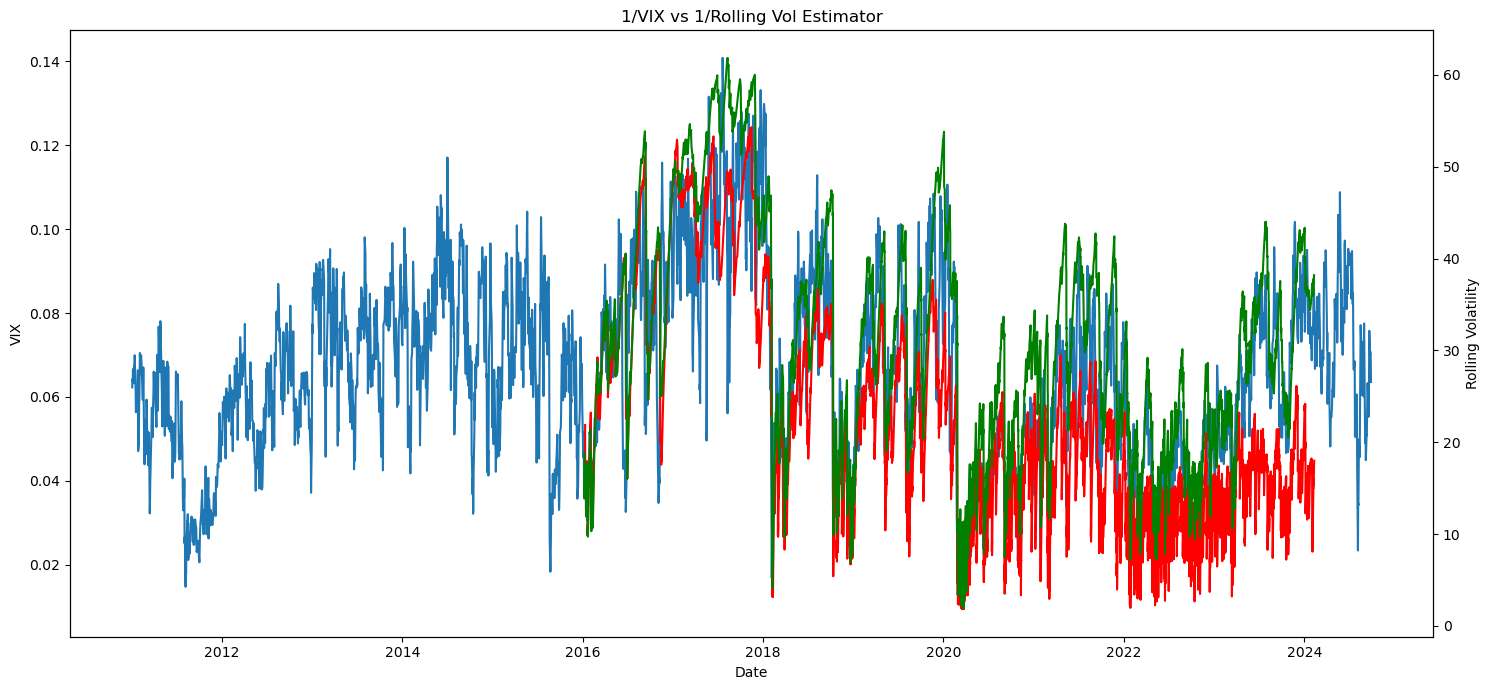

In [41]:
# Plot VIX and rolling_vol_moved_base with two y-axes

fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot VIX on the left y-axis (primary y-axis)
ax1.plot(1/vix_data["CLOSE"], label='VIX')
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot rolling_vol_moved_base on the right y-axis (secondary y-axis)
ax2.plot(1/np.sqrt(rolling_var_moved_base), label='1/Rolling Estimator', color='red')
ax2.plot(1/np.sqrt(rolling_var_moved_base_log), label='1/Rolling Estimator Log', color='green')
ax2.set_ylabel('Rolling Volatility')
ax2.tick_params(axis='y')

# Add a title and show the plot
plt.title("1/VIX vs 1/Rolling Vol Estimator")
fig.tight_layout()  # To avoid overlapping
plt.show()


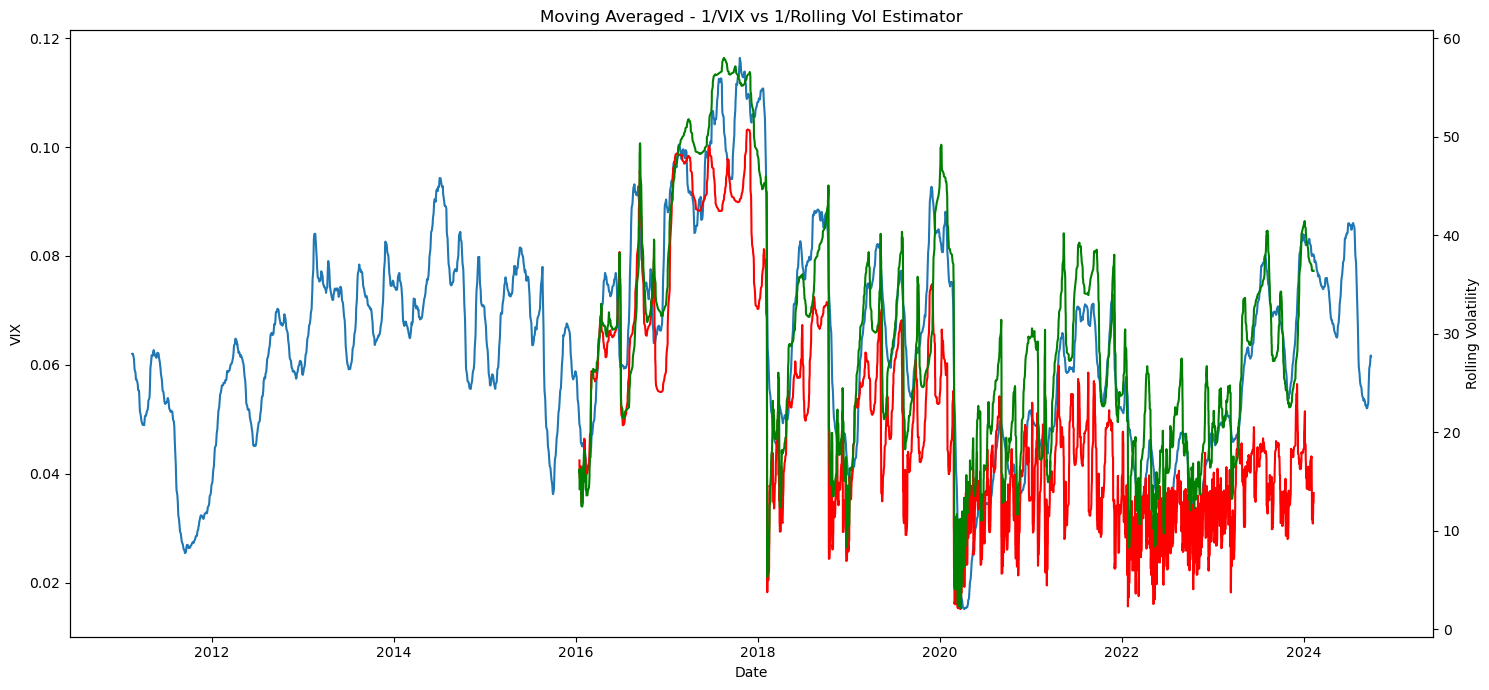

In [43]:
# Plot VIX and rolling_vol_moved_base with two y-axes

fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot VIX on the left y-axis (primary y-axis)
ax1.plot(1/vix_data["CLOSE"].rolling(30).mean(), label='VIX 30-Day MA')
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot rolling_vol_moved_base on the right y-axis (secondary y-axis)
ax2.plot(1/np.sqrt(rolling_var_moved_base).rolling(30).mean(), label='1/Rolling Estimator MA ', color='red')
ax2.plot(1/np.sqrt(rolling_var_moved_base_log).rolling(30).mean(), label='1/Rolling Estimator Log MA ', color='green')
ax2.set_ylabel('Rolling Volatility')
ax2.tick_params(axis='y')

# Add a title and show the plot
plt.title("Moving Averaged - 1/VIX vs 1/Rolling Vol Estimator")
fig.tight_layout()  # To avoid overlapping
plt.show()


In [44]:
log_price = np.log(close_data["SPY"])
log_price_diff = log_price.diff().dropna()
log_price_diff.head()

time
2015-12-31 19:03:00-05:00    0.000147
2015-12-31 19:05:00-05:00   -0.000343
2015-12-31 19:08:00-05:00    0.000196
2015-12-31 19:11:00-05:00    0.000196
2015-12-31 19:12:00-05:00   -0.000392
Name: SPY, dtype: float64

In [21]:
realized_volatility = log_price_diff.rolling(600*30).std()*np.sqrt(60*12*252)

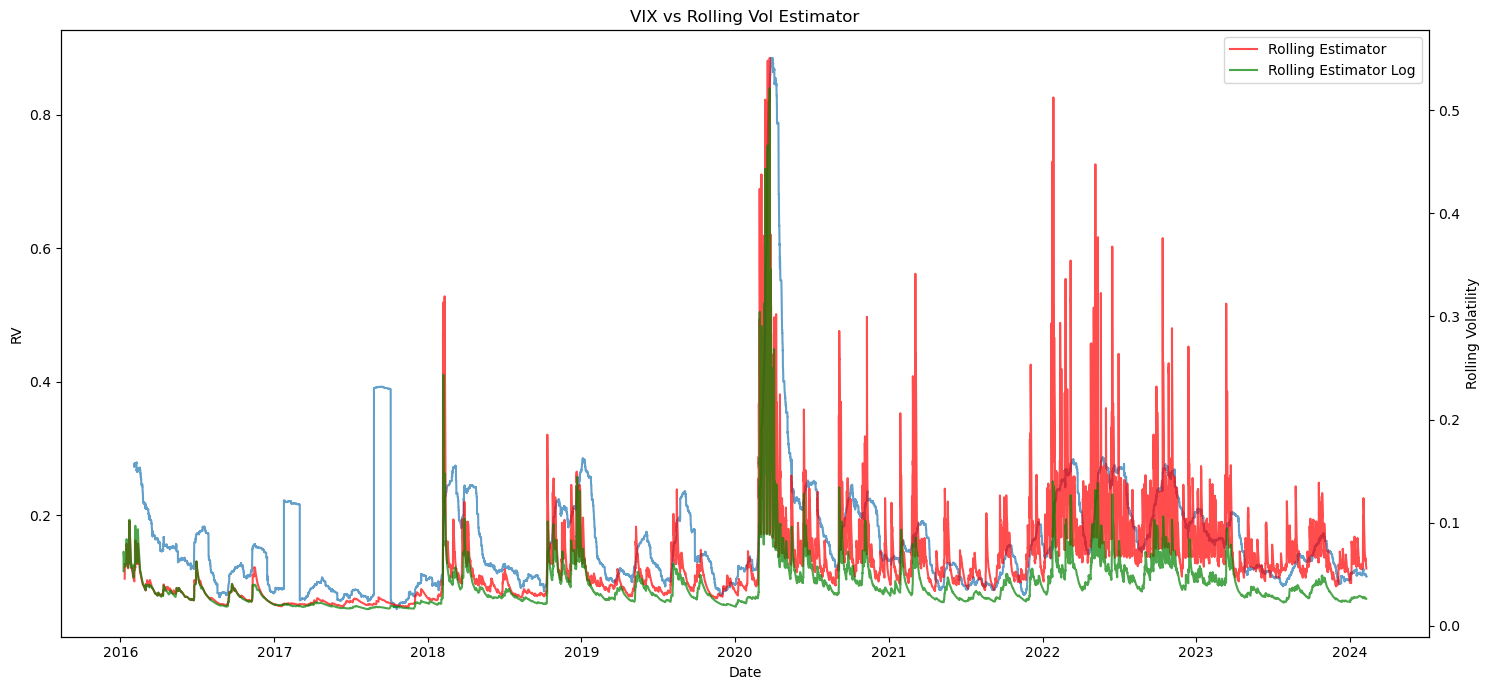

In [45]:
# Plot VIX and rolling_vol_moved_base with two y-axes

fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot VIX on the left y-axis (primary y-axis)
ax1.plot(realized_volatility, label='Realized Volatility', alpha = 0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('RV')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot rolling_vol_moved_base on the right y-axis (secondary y-axis)
ax2.plot(np.sqrt(rolling_var_moved_base), label='Rolling Estimator', color='red', alpha = 0.7)
ax2.plot(np.sqrt(rolling_var_moved_base_log), label='Rolling Estimator Log', color='green', alpha = 0.7)
ax2.set_ylabel('Rolling Volatility')
ax2.tick_params(axis='y')

# Add a title and show the plot
plt.title("VIX vs Rolling Vol Estimator")
fig.tight_layout()  # To avoid overlapping
# Show labels
plt.legend()
plt.show()


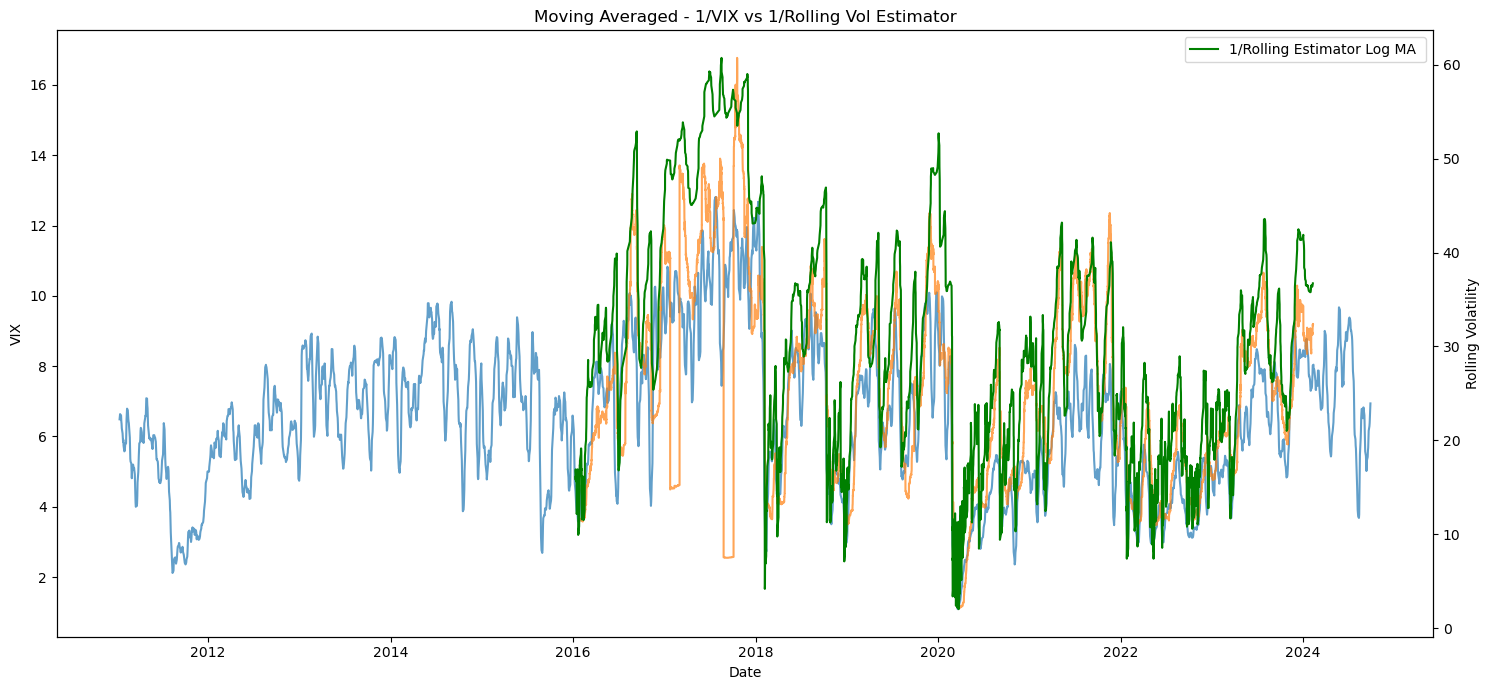

In [23]:
# Plot VIX and rolling_vol_moved_base with two y-axes

fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot VIX on the left y-axis (primary y-axis)
ax1.plot(1/(vix_data["CLOSE"]/100).rolling(7).mean(), label='VIX 30-Day MA', alpha = 0.7)
ax1.plot(1/realized_volatility.rolling(7).mean(), label='Realized Volatility - Time Based', alpha = 0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot rolling_vol_moved_base on the right y-axis (secondary y-axis)
ax2.plot(np.sqrt(rolling_var_moved_base_log).rolling(7).mean(), label='1/Rolling Estimator Log MA ', color='green')
ax2.set_ylabel('Rolling Volatility')
ax2.tick_params(axis='y')

# Add a title and show the plot
plt.title("Moving Averaged - 1/VIX vs 1/Rolling Vol Estimator")
fig.tight_layout()  # To avoid overlapping
# Show labels
plt.legend()
plt.show()


In [59]:
volatility_estimator_std = np.power(2*3/alpha ** 4 / diff_tau_df_log.apply(lambda x: x[0].total_seconds() / 60, axis = 1).rolling(window=30).var(), 1/4)

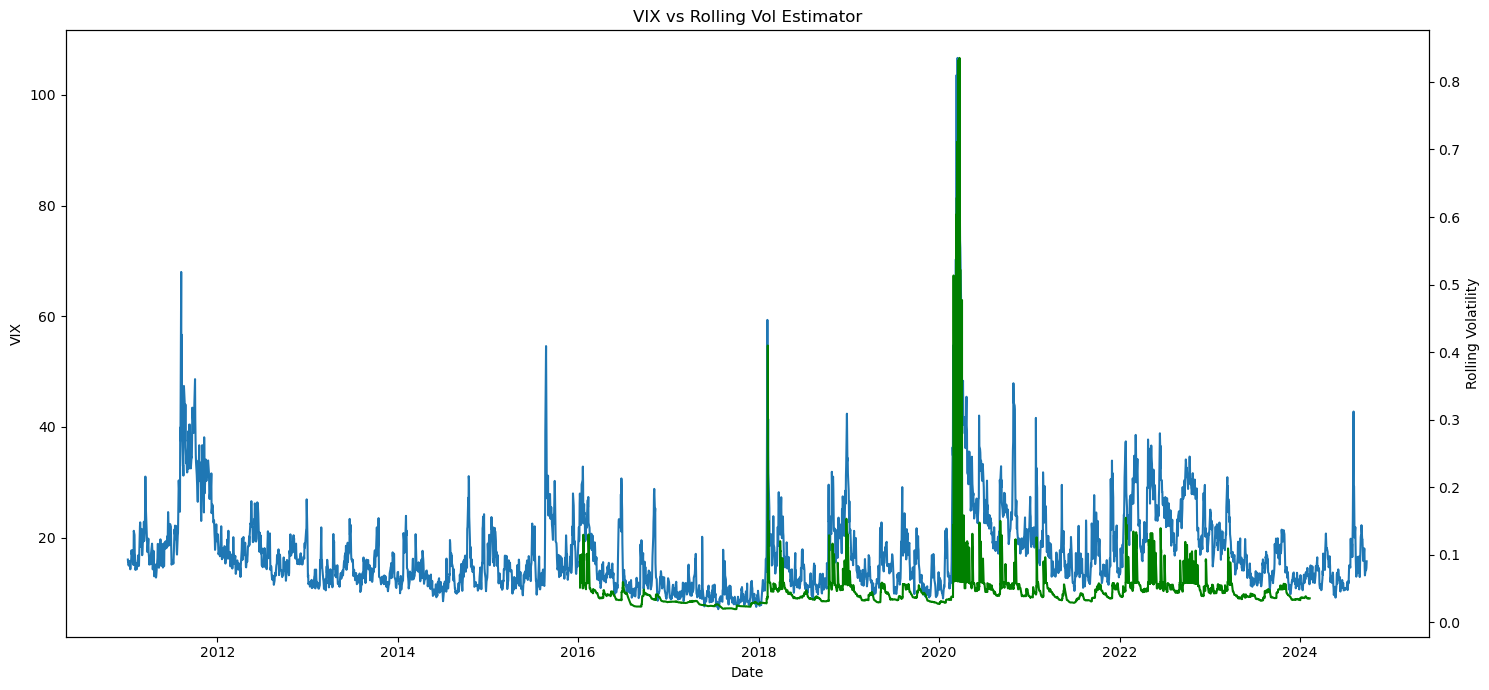

In [61]:
# Plot VIX and rolling_vol_moved_base with two y-axes

fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot VIX on the left y-axis (primary y-axis)
ax1.plot(vix_data["CLOSE"], label='VIX')
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot rolling_vol_moved_base on the right y-axis (secondary y-axis)
ax2.plot(volatility_estimator_std, label='Rolling Vol Estimator Log - var', color='green')
ax2.set_ylabel('Rolling Volatility')
ax2.tick_params(axis='y')

# Add a title and show the plot
plt.title("VIX vs Rolling Vol Estimator")
fig.tight_layout()  # To avoid overlapping
plt.show()


# Comparing the Volatility Estimator from second moment and fourth moment


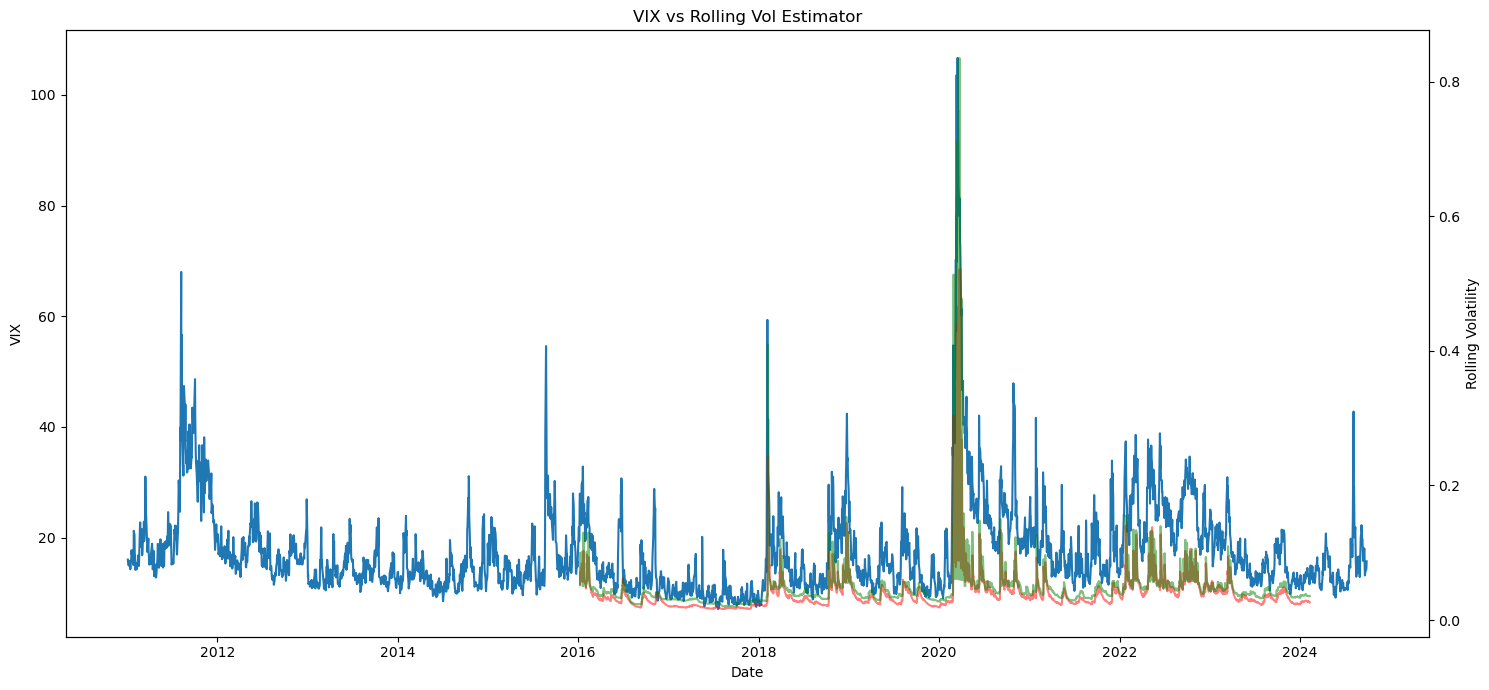

In [62]:
# Plot VIX and rolling_vol_moved_base with two y-axes
# Plot VIX and rolling_vol_moved_base with two y-axes

fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot VIX on the left y-axis (primary y-axis)
ax1.plot(vix_data["CLOSE"], label='VIX')
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot rolling_vol_moved_base on the right y-axis (secondary y-axis)
ax2.plot(np.sqrt(rolling_var_moved_base_log), label='Rolling Vol Estimator', color='red', alpha = 0.5)
ax2.plot(volatility_estimator_std, label='Rolling Vol Estimator Log - var', color='green', alpha = 0.5)
ax2.set_ylabel('Rolling Volatility')
ax2.tick_params(axis='y')

# Add a title and show the plot
plt.title("VIX vs Rolling Vol Estimator")
fig.tight_layout()  # To avoid overlapping
plt.show()


In [64]:
# Plot VIX and rolling_vol_moved_base with two y-axes

def plot_diff_window(window):
    rolling_var_moved_base_log_30 = alpha ** 2 / diff_tau_df_log.apply(lambda x: x[0].total_seconds() / 60, axis = 1).rolling(window=window).mean()
    volatility_estimator_std_30 = np.power(2*3/alpha ** 4 / diff_tau_df_log.apply(lambda x: x[0].total_seconds() / 60, axis = 1).rolling(window=window).var(), 1/4)
    
    plt.plot(np.sqrt(rolling_var_moved_base_log_30) - volatility_estimator_std_30, label='Rolling Vol Estimator', color='red', alpha = 0.8)
    # Add a title and show the plot
    plt.title("Estimator Difference with Window Size: " + str(window))
    fig.tight_layout()  # To avoid overlapping
    plt.show()


/var/folders/fb/bhld2vy11kjg5bh1hpblh9fm0000gn/T/ipykernel_31794/1589149691.py:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()  # To avoid overlapping


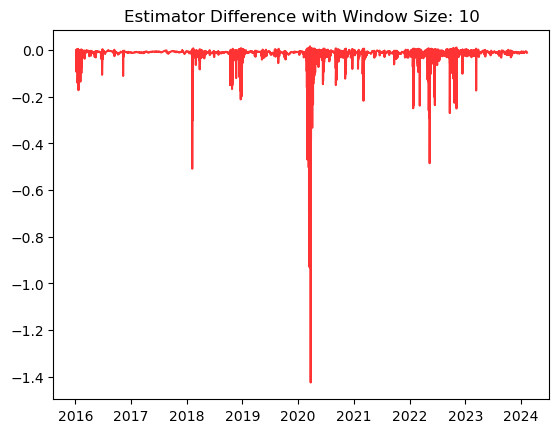

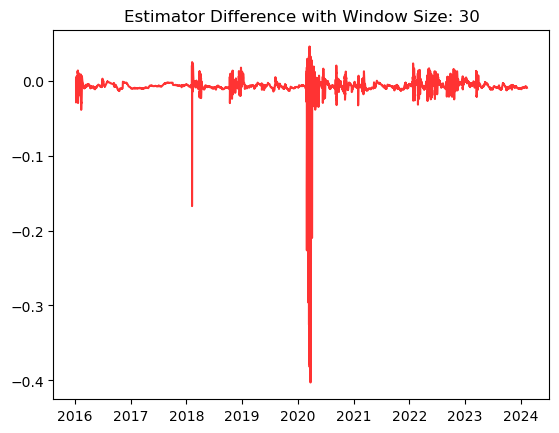

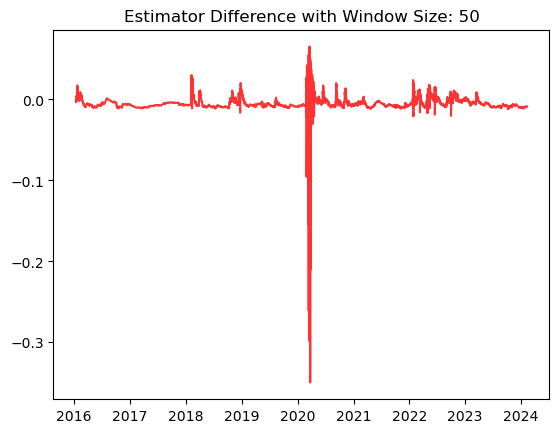

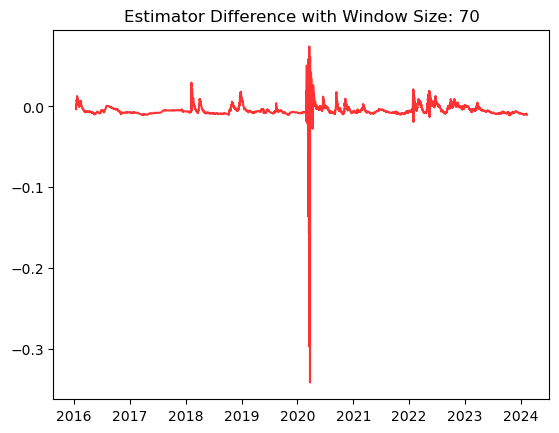

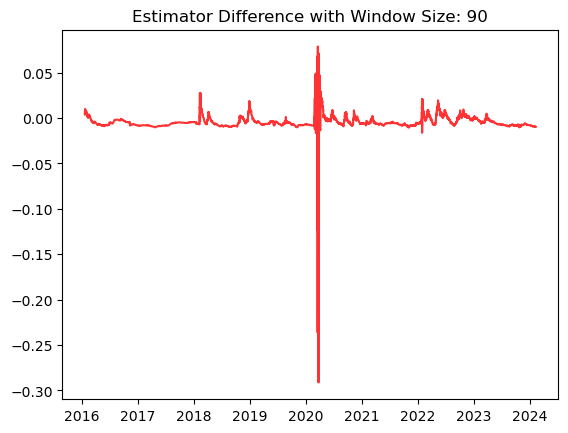

In [66]:
for window in range(10, 100, 20):
    plot_diff_window(window)